# ORFit Demo


# 0. Imports and Helper Functions

In [3]:
from typing import Sequence
from functools import partial

import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax.random as jr
from jax import jacrev
from jax import vmap
from jax.lax import scan
from jax.lax import cond
from jax.flatten_util import ravel_pytree
import flax.linen as nn

In [98]:
class MLP(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        for feat in self.features[:-1]:
            x = nn.relu(nn.Dense(feat)(x))
        x = nn.Dense(self.features[-1])(x)
        return x

def get_mlp_flattened_params(model_dims, key=0):
    if isinstance(key, int):
        key = jr.PRNGKey(key)

    # Define MLP model
    input_dim, features = model_dims[0], model_dims[1:]
    model = MLP(features)
    dummy_input = jnp.ones((input_dim,))

    # Initialize parameters using dummy input
    params = model.init(key, dummy_input)
    flat_params, unflatten_fn = ravel_pytree(params)

    # Define apply function
    def apply(flat_params, x, model, unflatten_fn):
        return model.apply(unflatten_fn(flat_params), jnp.atleast_1d(x))

    apply_fn = partial(apply, model=model, unflatten_fn=unflatten_fn)

    return model, flat_params, unflatten_fn, apply_fn

In [142]:
def plot_rmse(params_history, apply_fn, X, y, ax=None, title=''):
    if ax == None:
        fig, ax = plt.subplots()
    if title == None:
        title = 'RMSE'
    def compute_rmse(params, X, y):
        y_pred = vmap(apply_fn, (None, 0))(params, X)
        return jnp.sqrt(jnp.mean((y_pred - y)**2))
    rmses = vmap(compute_rmse, (0, None, None))(params_history, X, y)
    ax.plot(jnp.arange(len(rmses)), rmses)
    ax.set_title(title);
    return ax

In [174]:
eps = 1e-5
_perturb = lambda v: v + eps
_normalize = lambda v: _perturb(v) / jnp.linalg.norm(_perturb(v))
_project = lambda a, x: a * ((a.T @ x) / jnp.linalg.norm(a))
_project_to_columns = lambda A, x: \
    jnp.where(A.any(), vmap(_project, (1, None))(A, x).sum(axis=0), jnp.zeros(shape=x.shape))
_hstack = lambda A, x: \
    jnp.where(A.any(), jnp.hstack((A, x.reshape(-1, 1))), 10*jnp.ones((3,)))
_svd = lambda a: jnp.linalg.svd(a, full_matrices=False)

# 1. ORFit

Orthogonal Recursive Fitting (ORFit) is a memory-efficient approximation to the following exact update rule:

$$\begin{align}
     \tilde{g}_{i-1} &= \nabla \ell_{i}(w_{i-1}) - \sum_{v \in S_{i-1}} \text{proj}_{v}(\nabla \ell_i (w_{i-1})) \\
     S_i &= S_{i-1} \cup \{ \nabla f_i (w_{i-1}) - \sum_{v \in S_{i-1}} \text{proj}_{v}(\nabla f_i (w_{i-1})) \} \\
     w_i &= w_{i-1} - \eta_{i-1} \tilde{g}_{i-1} \\
     \eta_{i-1} &= \frac{f_i(w_{i-1}) - y_i}{\nabla f_i (w_{i-1})^{\intercal} \tilde{g}_{i-1}}
\end{align}$$
where instead of storing all past updates via $S_i$, it uses a rank-$m$ approximation by taking its top $m$ singular values using SVD.

In [190]:
def orthogonal_recursive_fitting(init_params, apply_fn, loss_fn, xs, ys, memory_limit):
    U, Sigma = jnp.zeros((len(init_params), 1)), jnp.array([])
    params = init_params

    params_history = []
    for t in range(len(xs)):
        x, y = xs[t], ys[t]
        current_loss_fn = lambda w: loss_fn(w, x, y)
        apply_params_fn = lambda w: apply_fn(w, x)
        g = jacrev(current_loss_fn)(params)
        f_prime = jacrev(apply_params_fn)(params)
        g_tilde = g - _project_to_columns(U, g.ravel())
        v_prime = f_prime - _project_to_columns(U, f_prime.ravel())

        if t <= memory_limit:
            if t == 0:
                U = v_prime.reshape(-1, 1)
            else:
                U = jnp.hstack((U, v_prime.reshape(-1, 1)))
            if t == memory_limit:
                U, Sigma, _ = _svd(U)
        else:
            u = _normalize(v_prime)
            tmp = jnp.diag(jnp.append(Sigma, u.ravel() @ v_prime.ravel()))
            U_tilde, Sigma, _ = _svd(jnp.diag(jnp.append(Sigma, u.ravel() @ v_prime.ravel())))
            U = jnp.hstack((U, u.reshape(-1, 1))) @ U_tilde
            U, Sigma = U[:, :memory_limit], Sigma[:memory_limit]
        eta = (apply_params_fn(params) - y) / _perturb(f_prime.ravel() @ g_tilde.ravel())
        params = params - eta * g_tilde.ravel()
        params_history.append(params)
        
    return jnp.array(params_history)

In [191]:
# # WIP: more efficient ORFit using lax.scan
# def orthogonal_recursive_fitting(init_params, apply_fn, loss_fn, xs, ys, memory_limit):
#     U, Sigma = jnp.zeros((len(init_params), memory_limit)), jnp.array([])

#     # Common step
#     def _step(carry, t):
#         params, U, Sigma = carry
#         x, y = xs[t], ys[t]
#         current_loss_fn = lambda w: loss_fn(w, x, y)
#         apply_params_fn = lambda w: apply_fn(w, x)
#         g = jacrev(current_loss_fn)(params)
#         v = jacrev(apply_params_fn)(params)
#         g_tilde = g - _project_to_columns(U, g.ravel())
#         v_prime = v - _project_to_columns(U, v.ravel())
    
#     # Step before reaching memory limit
#     def _step_before_limit(carry, t):
#         params, U, Sigma = carry
#         _step(carry, t)
    
#     def _step_after_limit(carry, t):
#         params, U, Sigma = carry
#         _step(carry, t)
        
    
#     params_history, _ = scan(_step, (init_params, U, Sigma), jnp.arange(len(xs)))

#     return params_history

# 2. Demo - Linear Regression

In [192]:
def generate_linreg_dataset(num_points=200, theta=jnp.array([2.5, 0.5]), var=0.05, key=1, shuffle=True):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    key, subkey = jr.split(key)
    X = jnp.linspace(0.0, 1.0, num_points)
    Y_tr = theta[1]*X + theta[0]
    noise = var*jr.normal(key, shape=(num_points,))
    Y = Y_tr + noise
    X_sh, Y_sh = X, Y
    # Shuffle data
    if shuffle:
        shuffle_idx = jr.permutation(subkey, jnp.arange(num_points))
        X_sh, Y_sh = X[shuffle_idx], Y[shuffle_idx]

    return X, X_sh, Y, Y_sh, Y_tr

In [193]:
X_lr, X_lr_sh, Y_lr, Y_lr_sh, Y_lr_tr = generate_linreg_dataset(100)

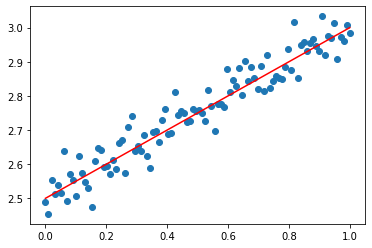

In [194]:
plt.scatter(X_lr, Y_lr)
plt.plot(X_lr, Y_lr_tr, c='red');

In [195]:
# Define Linear Regression as single layer perceptron
input_dim_lr, hidden_dims_lr, output_dim_lr = 1, [], 1
model_dims_lr = [input_dim_lr, *hidden_dims_lr, output_dim_lr]
_, flat_params_lr, _, apply_fn_lr = get_mlp_flattened_params(model_dims_lr)
print(flat_params_lr.shape)

(2,)


In [196]:
# L2 loss
loss_fn_lr = lambda w, x, y: (apply_fn_lr(w, x) - y)**2

# Run ORFit on linreg dataset
history_lr = orthogonal_recursive_fitting(flat_params_lr, apply_fn_lr, loss_fn_lr, X_lr, Y_lr, 20)

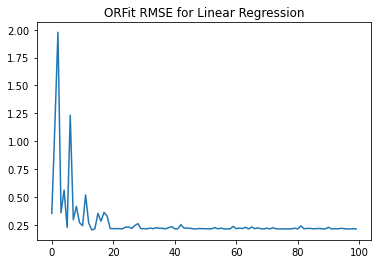

In [198]:
fig, ax = plt.subplots()
plot_rmse(history_lr, apply_fn_lr, X_lr, Y_lr, ax, 'ORFit RMSE for Linear Regression');

# 3. Demo - Nonlinear Regression

In [225]:
def generate_nonlinreg_dataset(num_points=200, fn=lambda x: jnp.sin(5*x**2 - 1), var=0.1, key=1, shuffle=True):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    key, subkey = jr.split(key)
    X = jnp.linspace(0.0, 1.0, num_points)
    Y_tr = vmap(fn)(X)
    noise = var*jr.normal(key, shape=(num_points,))
    Y = Y_tr + noise
    X_sh, Y_sh = X, Y
    
    # Shuffle data
    if shuffle:
        shuffle_idx = jr.permutation(subkey, jnp.arange(num_points))
        X_sh, Y_sh = X[shuffle_idx], Y[shuffle_idx]
    return X, X_sh, Y, Y_sh, Y_tr

In [226]:
X_nr, X_nr_sh, Y_nr, Y_nr_sh, Y_nr_tr = generate_nonlinreg_dataset()

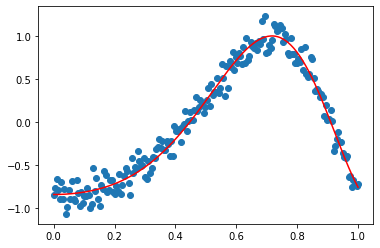

In [227]:
plt.scatter(X_nr, Y_nr)
plt.plot(X_nr, Y_nr_tr, c='red');

In [246]:
# Define Non-Linear Regression as MLP with two hidden layers
input_dim_nr, hidden_dims_nr, output_dim_nr = 1, [30, 30,], 1
model_dims_nr = [input_dim_nr, *hidden_dims_nr, output_dim_nr]
_, flat_params_nr, _, apply_fn_nr = get_mlp_flattened_params(model_dims_nr)
print(flat_params_nr.shape)

(1021,)


In [247]:
# L2 loss
loss_fn_nr = lambda w, x, y: (apply_fn_nr(w, x) - y)**2

# Run ORFit on linreg dataset
history_nr = orthogonal_recursive_fitting(flat_params_nr, apply_fn_nr, loss_fn_nr, X_nr_sh, Y_nr_sh, 20)

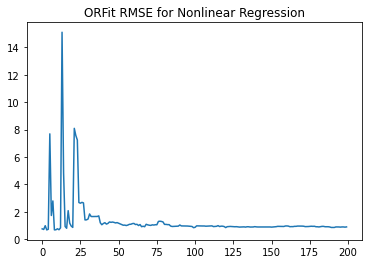

In [248]:
fig, ax = plt.subplots()
plot_rmse(history_nr, apply_fn_nr, X_nr_sh, Y_nr_sh, ax, 'ORFit RMSE for Nonlinear Regression');

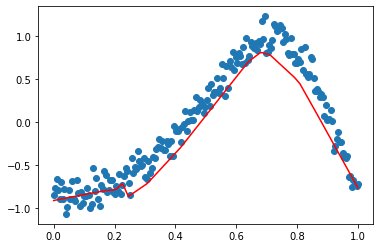

In [249]:
plt.scatter(X_nr, Y_nr)
plt.plot(X_nr, vmap(apply_fn_nr, (None, 0))(history_nr[-1], X_nr), c='red');

# 4. Demo - Rotating MNIST